In [1]:
import numpy as np

def ssk_kernel(s: str, t: str, n: int = 3, lam: float = 0.5) -> float:

    if n <= 0:
        return 1.0
    if lam <= 0 or lam > 1:
        raise ValueError("lam doit être dans (0, 1].")

    s = str(s)
    t = str(t)
    m, l = len(s), len(t)
    if min(m, l) < n:
        return 0.0

    # Kp[p, i, j] ~ kernel auxiliaire pour sous-séq de longueur p
    # sur prefixes s[:i], t[:j]
    Kp = np.zeros((n + 1, m + 1, l + 1), dtype=float)
    Kp[0, :, :] = 1.0

    for p in range(1, n + 1):
        for i in range(1, m + 1):
            acc = 0.0
            si = s[i - 1]
            for j in range(1, l + 1):
                if si == t[j - 1]:
                    acc = lam * (acc + lam * Kp[p - 1, i - 1, j - 1])
                else:
                    acc = lam * acc
                Kp[p, i, j] = acc

    # Kernel final
    K = 0.0
    for i in range(1, m + 1):
        si = s[i - 1]
        for j in range(1, l + 1):
            if si == t[j - 1]:
                K += (lam * lam) * Kp[n - 1, i - 1, j - 1]
    return float(K)


def ssk_kernel_norm(s: str, t: str, n: int = 3, lam: float = 0.5, cache=None) -> float:

    if cache is None:
        cache = {}
    key_s = ("self", s, n, lam)
    key_t = ("self", t, n, lam)

    if key_s not in cache:
        cache[key_s] = ssk_kernel(s, s, n=n, lam=lam)
    if key_t not in cache:
        cache[key_t] = ssk_kernel(t, t, n=n, lam=lam)

    denom = (cache[key_s] * cache[key_t]) ** 0.5
    if denom == 0.0:
        return 0.0
    return ssk_kernel(s, t, n=n, lam=lam) / denom


In [2]:
import matplotlib.pyplot as plt

def gram_matrix(texts, n=3, lam=0.5, normalized=True):
    N = len(texts)
    G = np.zeros((N, N), dtype=float)
    cache = {}  # pour K(s,s) si normalisé

    for i in range(N):
        for j in range(i, N):
            if normalized:
                kij = ssk_kernel_norm(texts[i], texts[j], n=n, lam=lam, cache=cache)
            else:
                kij = ssk_kernel(texts[i], texts[j], n=n, lam=lam)
            G[i, j] = G[j, i] = kij
    return G

def plot_similarity(G, labels=None, title="Matrice de similarité (SSK)"):
    plt.figure(figsize=(6, 5))
    plt.imshow(G, aspect="auto")
    plt.colorbar()
    if labels is not None:
        plt.xticks(range(len(labels)), labels, rotation=90)
        plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.tight_layout()
    plt.show()


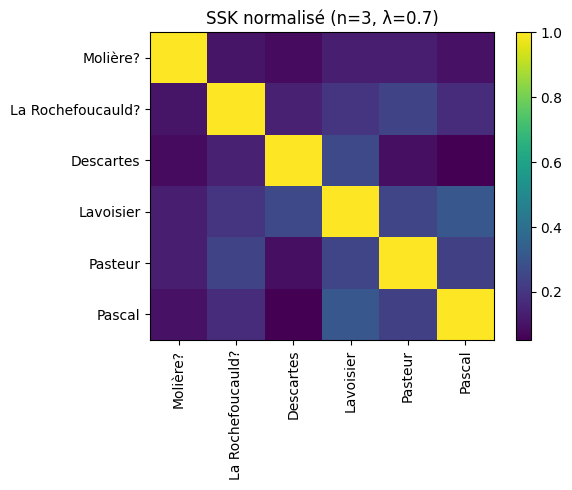

In [3]:
texts = [
    "Que diable allait-il faire dans cette galère ?",
    "L'hypocrisie est un vice à la mode, et tous les vices à la mode passent pour vertus.",
    "Je pense, donc je suis.",
    "Rien ne se perd, rien ne se crée, tout se transforme.",
    "Le hasard ne favorise que les esprits préparés.",
    "Le cœur a ses raisons que la raison ne connaît point."
]
labels = ["Molière?", "La Rochefoucauld?", "Descartes", "Lavoisier", "Pasteur", "Pascal"]
y = np.array([0, 0, 1, 1, 2, 2])

assert len(y) == len(texts)
G = gram_matrix(texts, n=3, lam=0.7, normalized=True)
plot_similarity(G, labels=labels, title="SSK normalisé (n=3, λ=0.7)")
